In [85]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import random
import os

# YOU NEED TO GO TO THE paths.py FILE AND PUT YOUR FOLDER OF IMAGES in the CAR_IMAGES_DIR variable
from paths import CAR_IMAGES_DIR  


INDIVIDUAL_IMG_PATHS = [CAR_IMAGES_DIR / image_name for image_name 
                        in os.listdir(CAR_IMAGES_DIR)]

## Utils functions for plotting

In [ ]:
#FUNCTIONS FOR PLOTTING VARIOS RESULTS
def plot_binary_methods():
    plt.figure(figsize=(15, 10))   # (width, height)
    methods = ['original', 'simple', 'adaptive', 'otsu', 'Gaus_otsu']
    
    for i in range(len(methods) * 3):
        pos = i % len(methods)
        if (pos == 0):
            image_path = random.choice(INDIVIDUAL_IMG_PATHS)
            
        image = binary_methods(image_path, method=methods[pos])
        plt.subplot(3, len(methods), i+1)
        plt.imshow(image, 'gray')
        plt.title(methods[pos])
        plt.xticks([]),plt.yticks([])
    
    plt.show()

def plot_mhorp_methods():
    plt.figure(figsize=(15, 10))   # (width, height)
    methods = ['original', 'dilation', 'erosion', 'opening', 'closing']
    
    for i in range(len(methods) * 3):
        pos = i % len(methods)
        if (pos == 0):
            image_path = random.choice(INDIVIDUAL_IMG_PATHS)
        
        binary_image = binary_methods(image_path, method = 'simple')
        output = mhorp_operations(binary_image, method = methods[pos], image_path=image_path)
        plt.subplot(3, len(methods), i+1)
        plt.imshow(output, 'gray')
        plt.title(methods[pos])
        plt.xticks([]),plt.yticks([])
    
    plt.show()

## Preprocessing of the images

In [96]:
def binary_methods(image_gray, method = 'simple'):
    #if method == 'original':
    #return image_rgb
    if method == 'simple':
        binary__image = cv.threshold(image_gray, 127, 255, 0)[1]

    elif method == 'adaptive':
        binary__image = cv.adaptiveThreshold(image_gray, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)

    elif method == 'otsu':
        _, binary__image = cv.threshold(image_gray, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)

    return binary__image

def mhorp_operations(binary_image, method = 'dilation', image_path = None):
    kernel = np.ones((2,7),np.uint8)
    
    if method == 'original':
        image = cv.imread(str(image_path))
        image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        return image_rgb
    
    if method == 'dilation':
        result = cv.dilate(binary_image, kernel, iterations = 1)

    elif method == 'erosion':
        result = cv.erode(binary_image, kernel, iterations = 1)

    elif method == 'opening':
        result = cv.morphologyEx(binary_image, cv.MORPH_OPEN, kernel)

    elif method == 'closing':
        result = cv.morphologyEx(binary_image, cv.MORPH_CLOSE, kernel)
        result = cv.morphologyEx(result, cv.MORPH_CLOSE, kernel)

    return result

# FUNCTION USED TO PREPROCESS A GIVEN IMAGE
def preprocess_image(image_path):
    #Open the image, and pass i to from BGR to RGB
    image = cv.imread(image_path)
    image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    #Image to gray scale. Apply also gaussian blur to reduce noise in the image
    image_gray = cv.cvtColor(image_rgb, cv.COLOR_RGB2GRAY)
    image_gray = cv.GaussianBlur(image_gray, (5, 5), 0)

    #Binarization doing one of the possible methods
    binary_image = binary_methods(image_gray, method='otsu')

    #Apply Mhorpological operations to the image using one of the possbile methods
    mhorp_image = mhorp_operations(binary_image, method = 'closing') 

    return mhorp_image  

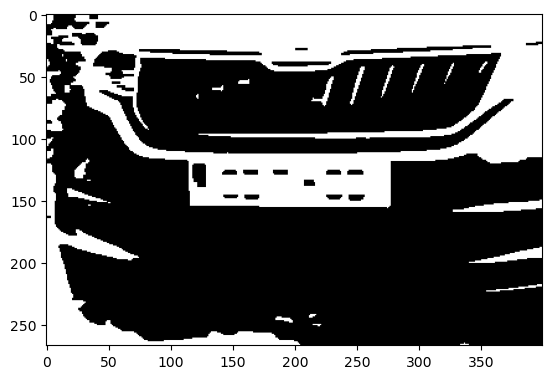

In [102]:
plt.imshow(preprocess_image(str(INDIVIDUAL_IMG_PATHS[12])), cmap='gray')

## Rectangle detection

### Method_1: Contour Approximation

In [65]:
import cv2
class ShapeDetector:
	def __init__(self):
		pass
	def detect(self, c):
		# initialize the shape name and approximate the contour
		shape = "unidentified"
		peri = cv2.arcLength(c, True)
		approx = cv2.approxPolyDP(c, 0.04 * peri, True)

        # if the shape is a triangle, it will have 3 vertices
		if len(approx) == 3:
			shape = "triangle"
		# if the shape has 4 vertices, it is either a square or
		# a rectangle
		elif len(approx) == 4:
			# compute the bounding box of the contour and use the
			# bounding box to compute the aspect ratio
			(x, y, w, h) = cv2.boundingRect(approx)
			ar = w / float(h)
			# a square will have an aspect ratio that is approximately
			# equal to one, otherwise, the shape is a rectangle
			shape = "square" if ar >= 0.95 and ar <= 1.05 else "rectangle"
		# if the shape is a pentagon, it will have 5 vertices
		elif len(approx) == 5:
			shape = "pentagon"
		# otherwise, we assume the shape is a circle
		else:
			shape = "circle"
		# return the name of the shape
		return shape

### Method_2: Canny detector